Importing Libraries & Dataset

In [4]:
import pandas as pd
import os

# Load all datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv')
holidays = pd.read_csv('holidays_events.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Data Preparation

In [5]:
df = [train, test, stores, oil, holidays, sample_submission]
names = ['train', 'test', 'stores', 'oil', 'holidays', 'sample_submission']

for name, x in zip(names, df):
    y = x.isnull().sum()
    print(f"Dataset {name}:\n{y}\n")

Dataset train:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Dataset test:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

Dataset stores:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Dataset oil:
date           0
dcoilwtico    43
dtype: int64

Dataset holidays:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Dataset sample_submission:
id       0
sales    0
dtype: int64



Check Missing Values

In [6]:
# Handle missing values in oil dataset
# Forward fill first, then backward fill for any remaining nulls
oil['dcoilwtico'] = oil['dcoilwtico'].ffill().bfill()

# Verify no more missing values
print("Missing values in oil after handling:")
print(oil.isnull().sum())
print("\nOil dataset info:")
print(oil.info())

Missing values in oil after handling:
date          0
dcoilwtico    0
dtype: int64

Oil dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1218 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None


Outlier Handling

Sales Statistics:
count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

Negative sales count: 0
Zero sales count: 939130
Zero sales percentage: 31.30%

Outliers detected (IQR method): 447105 (14.90%)
Lower bound: -293.77
Upper bound: 489.62


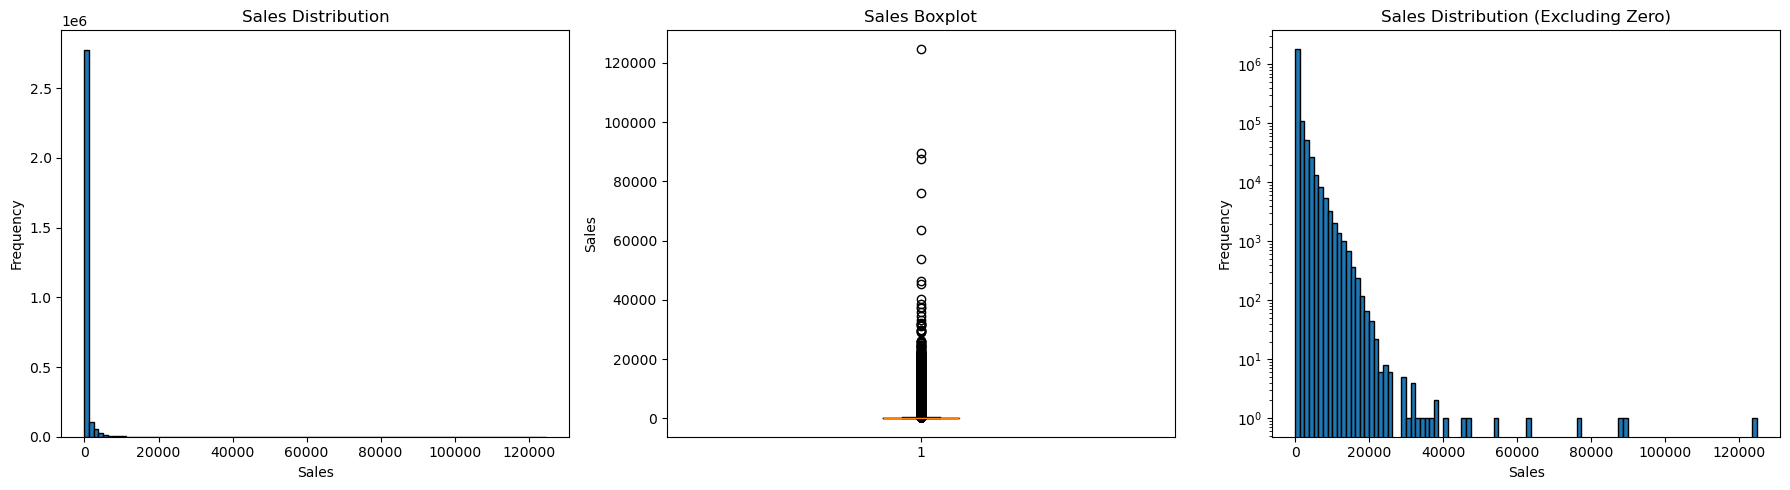


Top 10 highest sales records:
               date  store_nbr     family       sales  onpromotion
2163723  2016-05-02          2  GROCERY I  124717.000           59
2445984  2016-10-07         39      MEATS   89576.360            0
2144154  2016-04-21         20  GROCERY I   87438.516           53
2139699  2016-04-18         45  GROCERY I   76090.000           38
2153031  2016-04-26          2  GROCERY I   63434.000           30
2145045  2016-04-21         45  GROCERY I   53874.000           44
562596   2013-11-12         44  GROCERY I   46271.000            0
1257246  2014-12-08         35  GROCERY I   45361.000            3
1916586  2015-12-14         35  GROCERY I   40351.460            7
2760297  2017-04-02          9  GROCERY I   38422.625           73


In [7]:
# Check outliers in sales data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistics
print("Sales Statistics:")
print(train['sales'].describe())
print(f"\nNegative sales count: {(train['sales'] < 0).sum()}")
print(f"Zero sales count: {(train['sales'] == 0).sum()}")
print(f"Zero sales percentage: {(train['sales'] == 0).sum() / len(train) * 100:.2f}%")

# Check outliers using IQR method
Q1 = train['sales'].quantile(0.25)
Q3 = train['sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train[(train['sales'] < lower_bound) | (train['sales'] > upper_bound)]
print(f"\nOutliers detected (IQR method): {len(outliers)} ({len(outliers)/len(train)*100:.2f}%)")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(train['sales'], bins=100, edgecolor='black')
axes[0].set_title('Sales Distribution')
axes[0].set_xlabel('Sales')
axes[0].set_ylabel('Frequency')

# Boxplot
axes[1].boxplot(train['sales'])
axes[1].set_title('Sales Boxplot')
axes[1].set_ylabel('Sales')

# Log-scale histogram (for better view)
axes[2].hist(train[train['sales'] > 0]['sales'], bins=100, edgecolor='black')
axes[2].set_title('Sales Distribution (Excluding Zero)')
axes[2].set_xlabel('Sales')
axes[2].set_ylabel('Frequency')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

# Check sales by family (to see if outliers are category-specific)
print("\nTop 10 highest sales records:")
print(train.nlargest(10, 'sales')[['date', 'store_nbr', 'family', 'sales', 'onpromotion']])

Sales Statistics after Log Transform:
count    3.000888e+06
mean     2.926368e+00
std      2.695122e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.484907e+00
75%      5.282428e+00
max      1.173381e+01
Name: sales, dtype: float64


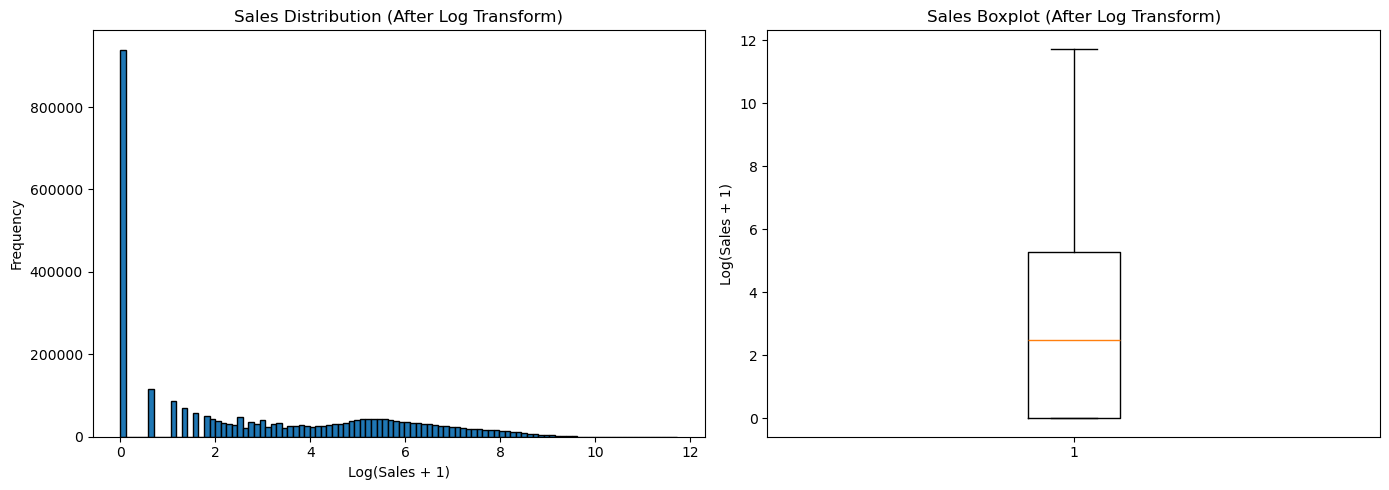


✓ Log transformation completed!
Note: Saat prediksi nanti, jangan lupa inverse transform dengan np.expm1()


In [8]:
# Log transform for sales to handle outliers and skewness
train['sales'] = np.log1p(train['sales'])  # log1p = log(1 + x), handle zero values

# Verify the transformation
print("Sales Statistics after Log Transform:")
print(train['sales'].describe())

# Visualize the transformed distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram after transform
axes[0].hist(train['sales'], bins=100, edgecolor='black')
axes[0].set_title('Sales Distribution (After Log Transform)')
axes[0].set_xlabel('Log(Sales + 1)')
axes[0].set_ylabel('Frequency')

# Boxplot after transform
axes[1].boxplot(train['sales'])
axes[1].set_title('Sales Boxplot (After Log Transform)')
axes[1].set_ylabel('Log(Sales + 1)')

plt.tight_layout()
plt.show()

print("\n✓ Log transformation completed!")
print("Note: Saat prediksi nanti, jangan lupa inverse transform dengan np.expm1()")

In [9]:
# ===== PREPARATION =====

# 1. Add flag to distinguish train and test
train['is_train'] = 1
test['is_train'] = 0

# 2. Concatenate train and test
# Note: test doesn't have 'sales' column, so we'll add it as NaN
test['sales'] = np.nan

# Combine both datasets
df = pd.concat([train, test], axis=0, ignore_index=True)

print("Combined dataset shape:", df.shape)
print("\nTrain samples:", df[df['is_train'] == 1].shape[0])
print("Test samples:", df[df['is_train'] == 0].shape[0])

# 3. Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

print("\n✓ Date columns converted to datetime")

# 4. Check the date range
print("\nDate range in combined data:")
print(f"Start: {df['date'].min()}")
print(f"End: {df['date'].max()}")

print("\nDate range in oil data:")
print(f"Start: {oil['date'].min()}")
print(f"End: {oil['date'].max()}")

print("\nDate range in holidays data:")
print(f"Start: {holidays['date'].min()}")
print(f"End: {holidays['date'].max()}")

# 5. Verify the structure
print("\nCombined dataframe info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nLast few rows (should be test data):")
print(df.tail())

Combined dataset shape: (3029400, 7)

Train samples: 3000888
Test samples: 28512

✓ Date columns converted to datetime

Date range in combined data:
Start: 2013-01-01 00:00:00
End: 2017-08-31 00:00:00

Date range in oil data:
Start: 2013-01-01 00:00:00
End: 2017-08-31 00:00:00

Date range in holidays data:
Start: 2012-03-02 00:00:00
End: 2017-12-26 00:00:00

Combined dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029400 entries, 0 to 3029399
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   is_train     int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 161.8+ MB
None

First few rows:
   id       date  store_nbr      family  sales  onpromotion  is_train
0   0 2013-01-01          1  A

In [10]:
# ===== MERGING WITH OTHER DATASETS =====

# 1. Merge with stores (by store_nbr)
df = df.merge(stores, on='store_nbr', how='left')
print("After merging with stores:")
print(f"Shape: {df.shape}")
print(f"New columns: {['city', 'state', 'type', 'cluster']}")
print(f"Missing values:\n{df[['city', 'state', 'type', 'cluster']].isnull().sum()}\n")

# 2. Merge with oil (by date)
df = df.merge(oil, on='date', how='left')
print("After merging with oil:")
print(f"Shape: {df.shape}")
print(f"New columns: ['dcoilwtico']")
print(f"Missing values in dcoilwtico: {df['dcoilwtico'].isnull().sum()}")

# Handle missing oil prices (in case there are dates not in oil dataset)
df['dcoilwtico'] = df['dcoilwtico'].ffill().bfill()
print(f"After ffill/bfill: {df['dcoilwtico'].isnull().sum()} missing values\n")

# 3. Merge with holidays (by date)
# Create a flag for holidays instead of merging all columns
# This prevents duplicates and is more efficient
holidays_dates = holidays[['date']].drop_duplicates()
holidays_dates['is_holiday'] = 1

df = df.merge(holidays_dates, on='date', how='left')
df['is_holiday'] = df['is_holiday'].fillna(0).astype(int)

print("After merging with holidays:")
print(f"Shape: {df.shape}")
print(f"New columns: ['is_holiday']")
print(f"Holiday count: {df['is_holiday'].sum()}")
print(f"Holiday percentage: {df['is_holiday'].mean() * 100:.2f}%\n")

# 4. Verify final merged dataset
print("="*50)
print("FINAL MERGED DATASET INFO:")
print("="*50)
print(f"Total rows: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nMissing values per column:")
print(df.isnull().sum())
print(f"\nDataframe info:")
print(df.info())

After merging with stores:
Shape: (3029400, 11)
New columns: ['city', 'state', 'type', 'cluster']
Missing values:
city       0
state      0
type       0
cluster    0
dtype: int64

After merging with oil:
Shape: (3029400, 12)
New columns: ['dcoilwtico']
Missing values in dcoilwtico: 864270
After ffill/bfill: 0 missing values

After merging with holidays:
Shape: (3029400, 13)
New columns: ['is_holiday']
Holiday count: 450846
Holiday percentage: 14.88%

FINAL MERGED DATASET INFO:
Total rows: 3029400
Total columns: 13

Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'is_train', 'city', 'state', 'type', 'cluster', 'dcoilwtico', 'is_holiday']

Missing values per column:
id                 0
date               0
store_nbr          0
family             0
sales          28512
onpromotion        0
is_train           0
city               0
state              0
type               0
cluster            0
dcoilwtico         0
is_holiday         0
dtype: int64

Dataframe info:
<

In [11]:
# ===== EXTRACT DATE FEATURES =====

# 1. Basic date components
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
df['quarter'] = df['date'].dt.quarter

print("Basic date features extracted:")
print(['year', 'month', 'day', 'day_of_week', 'day_of_year', 'week_of_year', 'quarter'])

# 2. Special date flags
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)  # Saturday=5, Sunday=6
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
df['is_year_start'] = df['date'].dt.is_year_start.astype(int)
df['is_year_end'] = df['date'].dt.is_year_end.astype(int)

print("\nSpecial date flags created:")
print(['is_weekend', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end'])

# 3. Days to payday (assume payday is 15th and end of month)
df['days_to_payday'] = df['day'].apply(lambda x: min(abs(x - 15), abs(x - 31)))

print("\nPayday feature created: 'days_to_payday'")

# 4. Verify all new features
print("\n" + "="*50)
print("DATE FEATURES SUMMARY:")
print("="*50)
print(f"Total columns now: {len(df.columns)}")
print(f"\nAll columns: {list(df.columns)}")

# Show sample of date features
print("\nSample of date features:")
date_features = ['date', 'year', 'month', 'day', 'day_of_week', 'week_of_year', 
                 'is_weekend', 'is_holiday', 'is_month_end', 'days_to_payday']
print(df[date_features].head(10))

# Check value distributions
print("\nValue distributions:")
print(f"Weekends: {df['is_weekend'].sum()} ({df['is_weekend'].mean()*100:.2f}%)")
print(f"Holidays: {df['is_holiday'].sum()} ({df['is_holiday'].mean()*100:.2f}%)")
print(f"Month starts: {df['is_month_start'].sum()}")
print(f"Month ends: {df['is_month_end'].sum()}")

print("\n✓ Date feature extraction completed!")

Basic date features extracted:
['year', 'month', 'day', 'day_of_week', 'day_of_year', 'week_of_year', 'quarter']

Special date flags created:
['is_weekend', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end']

Payday feature created: 'days_to_payday'

DATE FEATURES SUMMARY:
Total columns now: 28

All columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'is_train', 'city', 'state', 'type', 'cluster', 'dcoilwtico', 'is_holiday', 'year', 'month', 'day', 'day_of_week', 'day_of_year', 'week_of_year', 'quarter', 'is_weekend', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end', 'days_to_payday']

Sample of date features:
        date  year  month  day  day_of_week  week_of_year  is_weekend  \
0 2013-01-01  2013      1    1            1             1           0   
1 2013-01-01  2013      1    1            1             1           0   
2 2013-01-01  2013      1    1       

In [12]:
# ===== ENCODE CATEGORICAL VARIABLES =====

from sklearn.preprocessing import LabelEncoder

# Make a copy of categorical columns for reference
categorical_cols = ['family', 'city', 'state', 'type']

print("Categorical columns to encode:", categorical_cols)
print("\nUnique values per column:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

# Initialize label encoders dictionary to store encoders (useful for future use)
label_encoders = {}

# 1. Encode each categorical column
for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le
    
    print(f"\n✓ Encoded '{col}' -> '{col}_encoded'")
    print(f"  Sample mapping: {dict(list(zip(le.classes_[:5], range(5))))}")

# 2. Verify encoding
print("\n" + "="*50)
print("ENCODING SUMMARY:")
print("="*50)

# Show before and after for a sample
print("\nSample - Original vs Encoded:")
sample_cols = ['family', 'family_encoded', 'city', 'city_encoded', 'type', 'type_encoded']
print(df[sample_cols].head(10))

# Check if any missing values in encoded columns
encoded_cols = [col + '_encoded' for col in categorical_cols]
print(f"\nMissing values in encoded columns:")
print(df[encoded_cols].isnull().sum())

# 3. Optional: Drop original categorical columns to save memory
# (Keep them for now, we can drop later if needed)
print(f"\n✓ Categorical encoding completed!")
print(f"New encoded columns: {encoded_cols}")
print(f"Total columns now: {len(df.columns)}")

# Show all columns
print(f"\nAll columns: {list(df.columns)}")

Categorical columns to encode: ['family', 'city', 'state', 'type']

Unique values per column:
family: 33 unique values
city: 22 unique values
state: 16 unique values
type: 5 unique values

✓ Encoded 'family' -> 'family_encoded'
  Sample mapping: {'AUTOMOTIVE': 0, 'BABY CARE': 1, 'BEAUTY': 2, 'BEVERAGES': 3, 'BOOKS': 4}

✓ Encoded 'city' -> 'city_encoded'
  Sample mapping: {'Ambato': 0, 'Babahoyo': 1, 'Cayambe': 2, 'Cuenca': 3, 'Daule': 4}

✓ Encoded 'state' -> 'state_encoded'
  Sample mapping: {'Azuay': 0, 'Bolivar': 1, 'Chimborazo': 2, 'Cotopaxi': 3, 'El Oro': 4}

✓ Encoded 'type' -> 'type_encoded'
  Sample mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}

ENCODING SUMMARY:

Sample - Original vs Encoded:
         family  family_encoded   city  city_encoded type  type_encoded
0    AUTOMOTIVE               0  Quito            18    D             3
1     BABY CARE               1  Quito            18    D             3
2        BEAUTY               2  Quito            18    D           

In [13]:
# ===== LAG FEATURES & ROLLING STATISTICS =====
# WARNING: This process might take 5-15 minutes due to large dataset!

print("Starting Lag & Rolling Features creation...")
print("This might take several minutes, please wait...\n")

# 1. Sort data by store_nbr, family, and date (CRUCIAL!)
df = df.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)
print("✓ Data sorted by store_nbr, family, and date")

# 2. Create a copy of sales for train only (to avoid data leakage)
# We'll use this to create features, then apply to both train and test
df['sales_for_features'] = df['sales'].copy()
# Set test sales to NaN so they don't leak into lag/rolling calculations
df.loc[df['is_train'] == 0, 'sales_for_features'] = np.nan

print("✓ Sales copied for feature creation (test sales set to NaN)")

# 3. Create Lag Features
print("\nCreating lag features...")
lag_days = [7, 14, 28]

for lag in lag_days:
    df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales_for_features'].shift(lag)
    print(f"  ✓ sales_lag_{lag} created")

# 4. Create Rolling Mean Features
print("\nCreating rolling mean features...")
rolling_windows = [7, 14, 28]

for window in rolling_windows:
    df[f'sales_rolling_mean_{window}'] = df.groupby(['store_nbr', 'family'])['sales_for_features'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    )
    print(f"  ✓ sales_rolling_mean_{window} created")

# 5. Create Rolling Std Features (volatility measure)
print("\nCreating rolling std features...")
df['sales_rolling_std_7'] = df.groupby(['store_nbr', 'family'])['sales_for_features'].transform(
    lambda x: x.shift(1).rolling(window=7, min_periods=1).std()
)
print("  ✓ sales_rolling_std_7 created")

# 6. Create Promotion Rolling Sum (total promo days in last 7 days)
print("\nCreating promotion rolling features...")
df['promo_rolling_sum_7'] = df.groupby(['store_nbr', 'family'])['onpromotion'].transform(
    lambda x: x.shift(1).rolling(window=7, min_periods=1).sum()
)
print("  ✓ promo_rolling_sum_7 created")

# 7. Drop the temporary column
df = df.drop('sales_for_features', axis=1)

# 8. Check for missing values in new features
print("\n" + "="*50)
print("LAG & ROLLING FEATURES SUMMARY:")
print("="*50)

lag_rolling_cols = [f'sales_lag_{lag}' for lag in lag_days] + \
                   [f'sales_rolling_mean_{window}' for window in rolling_windows] + \
                   ['sales_rolling_std_7', 'promo_rolling_sum_7']

print(f"\nNew features created: {len(lag_rolling_cols)}")
print(f"Features: {lag_rolling_cols}")

print(f"\nMissing values in new features:")
print(df[lag_rolling_cols].isnull().sum())

print(f"\nMissing value percentages:")
for col in lag_rolling_cols:
    missing_pct = df[col].isnull().sum() / len(df) * 100
    print(f"  {col}: {missing_pct:.2f}%")

# 9. Show sample of features
print("\nSample of lag & rolling features:")
sample_cols = ['date', 'store_nbr', 'family', 'sales', 'sales_lag_7', 
               'sales_rolling_mean_7', 'sales_rolling_std_7', 'promo_rolling_sum_7']
print(df[df['is_train'] == 1][sample_cols].head(30))

print("\n✓ Lag & Rolling features creation completed!")
print(f"Total columns now: {len(df.columns)}")

Starting Lag & Rolling Features creation...
This might take several minutes, please wait...

✓ Data sorted by store_nbr, family, and date
✓ Sales copied for feature creation (test sales set to NaN)

Creating lag features...
  ✓ sales_lag_7 created
  ✓ sales_lag_14 created
  ✓ sales_lag_28 created

Creating rolling mean features...
  ✓ sales_rolling_mean_7 created
  ✓ sales_rolling_mean_14 created
  ✓ sales_rolling_mean_28 created

Creating rolling std features...
  ✓ sales_rolling_std_7 created

Creating promotion rolling features...
  ✓ promo_rolling_sum_7 created

LAG & ROLLING FEATURES SUMMARY:

New features created: 8
Features: ['sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_rolling_mean_7', 'sales_rolling_mean_14', 'sales_rolling_mean_28', 'sales_rolling_std_7', 'promo_rolling_sum_7']

Missing values in new features:
sales_lag_7              28512
sales_lag_14             28512
sales_lag_28             49896
sales_rolling_mean_7     17820
sales_rolling_mean_14     5346
sale

In [14]:
# ===== TAHAP 3: HANDLE MISSING VALUES FROM NEW FEATURES =====

print("="*50)
print("TAHAP 3: HANDLING MISSING VALUES")
print("="*50)

# 1. Check missing values
print("\nMissing values before handling:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# 2. Fill missing values in lag and rolling features
# Strategy: Fill with 0 (representing no sales history)
lag_rolling_cols = [col for col in df.columns if 'lag' in col or 'rolling' in col]

print(f"\nFilling missing values in {len(lag_rolling_cols)} lag/rolling features with 0...")
for col in lag_rolling_cols:
    df[col] = df[col].fillna(0)
    
print("✓ Missing values filled")

# 3. Verify no missing values (except sales in test which is expected)
print("\nMissing values after handling:")
print(df.isnull().sum()[df.isnull().sum() > 0])

print("\n✓ Tahap 3 completed!")

# ===== TAHAP 4: SPLIT TRAIN & TEST KEMBALI =====

print("\n" + "="*50)
print("TAHAP 4: SPLIT TRAIN & TEST")
print("="*50)

# 1. Separate train and test
train_df = df[df['is_train'] == 1].copy()
test_df = df[df['is_train'] == 0].copy()

print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# 2. Define features to drop
cols_to_drop = ['is_train', 'date', 'id']  # Drop flags and non-feature columns
# Also drop original categorical columns (we have encoded versions)
categorical_original = ['family', 'city', 'state', 'type']
cols_to_drop.extend(categorical_original)

print(f"\nColumns to drop: {cols_to_drop}")

# 3. Prepare feature columns (all except sales and cols_to_drop)
feature_cols = [col for col in train_df.columns if col not in cols_to_drop + ['sales']]

print(f"\nTotal feature columns: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")

# 4. Create X_train, y_train, X_test
X_train = train_df[feature_cols].copy()
y_train = train_df['sales'].copy()  # Already log-transformed
X_test = test_df[feature_cols].copy()

# Keep id and date for submission later
test_id = test_df['id'].copy()
test_date = test_df['date'].copy()

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

# 5. Verify no missing values in features
print(f"\nMissing values in X_train: {X_train.isnull().sum().sum()}")
print(f"Missing values in X_test: {X_test.isnull().sum().sum()}")
print(f"Missing values in y_train: {y_train.isnull().sum()}")

# 6. Show feature summary
print("\n" + "="*50)
print("FEATURE SUMMARY:")
print("="*50)
print(f"Total features: {len(feature_cols)}")
print(f"\nFeature types:")
print(X_train.dtypes.value_counts())

print("\n✓ Tahap 4 completed!")
print("\nReady for Model Training!")

# Display first few rows of train features
print("\nSample X_train:")
print(X_train.head())
print("\nSample y_train (log-transformed sales):")
print(y_train.head())

TAHAP 3: HANDLING MISSING VALUES

Missing values before handling:
sales                    28512
sales_lag_7              28512
sales_lag_14             28512
sales_lag_28             49896
sales_rolling_mean_7     17820
sales_rolling_mean_14     5346
sales_rolling_mean_28     1782
sales_rolling_std_7      21384
promo_rolling_sum_7       1782
dtype: int64

Filling missing values in 8 lag/rolling features with 0...
✓ Missing values filled

Missing values after handling:
sales    28512
dtype: int64

✓ Tahap 3 completed!

TAHAP 4: SPLIT TRAIN & TEST

Train shape: (3000888, 40)
Test shape: (28512, 40)

Columns to drop: ['is_train', 'date', 'id', 'family', 'city', 'state', 'type']

Total feature columns: 32
Feature columns: ['store_nbr', 'onpromotion', 'cluster', 'dcoilwtico', 'is_holiday', 'year', 'month', 'day', 'day_of_week', 'day_of_year', 'week_of_year', 'quarter', 'is_weekend', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end', 'day

Model :- XGBOOST

In [18]:
import xgboost as xgb
print(xgb.__version__)

3.2.0


In [19]:
# ===== TAHAP 5: MODEL TRAINING WITH XGBOOST =====

print("="*50)
print("TAHAP 5: TRAINING MODEL WITH XGBOOST")
print("="*50)

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. TIME-BASED TRAIN-VALIDATION SPLIT
# Use last 15 days of train data as validation
print("\n1. Creating Time-Based Train-Validation Split...")

# Get unique dates and sort
unique_dates = sorted(train_df['date'].unique())
print(f"Total unique dates in train: {len(unique_dates)}")
print(f"Date range: {unique_dates[0]} to {unique_dates[-1]}")

# Split: last 15 days for validation
val_days = 15
val_start_date = unique_dates[-val_days]

print(f"\nValidation start date: {val_start_date}")
print(f"Validation will use last {val_days} days")

# Create train and validation sets
train_mask = train_df['date'] < val_start_date
val_mask = train_df['date'] >= val_start_date

X_tr = X_train[train_mask]
y_tr = y_train[train_mask]
X_val = X_train[val_mask]
y_val = y_train[val_mask]

print(f"\nTrain set: {X_tr.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Train ratio: {X_tr.shape[0]/X_train.shape[0]*100:.2f}%")
print(f"Val ratio: {X_val.shape[0]/X_train.shape[0]*100:.2f}%")

# 2. PREPARE XGBOOST DATASETS
print("\n2. Preparing XGBoost DMatrix...")
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

print("✓ DMatrix created")

# 3. SET XGBOOST PARAMETERS
print("\n3. Setting XGBoost parameters...")
params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',             # Root Mean Squared Error
    'eta': 0.1,                        # Learning rate (0.1 is safe default)
    'max_depth': 8,                    # Tree depth
    'subsample': 0.8,                  # Sample 80% of data for each tree
    'colsample_bytree': 0.8,           # Sample 80% of features for each tree
    'min_child_weight': 3,             # Minimum sum of weights in a child
    'seed': 42,                        # Reproducibility
    'tree_method': 'hist',             # Faster training for large datasets
    'verbosity': 1                     # Show progress
}

print("Parameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

# 4. TRAIN MODEL
print("\n4. Training XGBoost model...")
print("This might take several minutes...\n")

num_rounds = 500  # Number of boosting rounds
early_stopping_rounds = 50  # Stop if no improvement for 50 rounds

evals = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_rounds,
    evals=evals,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=50  # Print every 50 rounds
)

print(f"\n✓ Training completed!")
print(f"Best iteration: {model.best_iteration}")
print(f"Best score: {model.best_score:.6f}")

# 5. EVALUATE ON VALIDATION SET
print("\n5. Evaluating on validation set...")
y_val_pred = model.predict(dval)

# Calculate RMSE (on log scale)
rmse_log = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE (log scale): {rmse_log:.6f}")

# Calculate RMSLE (on original scale)
y_val_original = np.expm1(y_val)
y_val_pred_original = np.expm1(y_val_pred)
# Clip negative predictions to 0
y_val_pred_original = np.maximum(0, y_val_pred_original)

rmsle = np.sqrt(mean_squared_error(np.log1p(y_val_original), np.log1p(y_val_pred_original)))
print(f"Validation RMSLE (original scale): {rmsle:.6f}")

# 6. FEATURE IMPORTANCE
print("\n6. Top 20 Most Important Features:")
importance_dict = model.get_score(importance_type='gain')
importance_sorted = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]

for i, (feature, score) in enumerate(importance_sorted, 1):
    print(f"{i:2d}. {feature:30s}: {score:.2f}")

print("\n✓ Model training completed successfully!")
print("\nReady for prediction on test set!")

TAHAP 5: TRAINING MODEL WITH XGBOOST

1. Creating Time-Based Train-Validation Split...
Total unique dates in train: 1684
Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00

Validation start date: 2017-08-01 00:00:00
Validation will use last 15 days

Train set: 2974158 samples
Validation set: 26730 samples
Train ratio: 99.11%
Val ratio: 0.89%

2. Preparing XGBoost DMatrix...
✓ DMatrix created

3. Setting XGBoost parameters...
Parameters:
  objective: reg:squarederror
  eval_metric: rmse
  eta: 0.1
  max_depth: 8
  subsample: 0.8
  colsample_bytree: 0.8
  min_child_weight: 3
  seed: 42
  tree_method: hist
  verbosity: 1

4. Training XGBoost model...
This might take several minutes...

[0]	train-rmse:2.43462	val-rmse:2.36289
[50]	train-rmse:0.40113	val-rmse:0.39147
[100]	train-rmse:0.38124	val-rmse:0.38937
[150]	train-rmse:0.37213	val-rmse:0.38718
[200]	train-rmse:0.36628	val-rmse:0.38486
[250]	train-rmse:0.36215	val-rmse:0.38341
[300]	train-rmse:0.35788	val-rmse:0.38318
[350]	train-r

Lightgbm

In [23]:
# ===== TRAINING WITH LIGHTGBM =====

print("="*50)
print("TRAINING MODEL WITH LIGHTGBM")
print("="*50)

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. PREPARE LIGHTGBM DATASETS
print("\n1. Preparing LightGBM datasets...")

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_tr, label=y_tr)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

print("✓ LightGBM datasets created")
print(f"Train set: {X_tr.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

# 2. SET LIGHTGBM PARAMETERS
print("\n2. Setting LightGBM parameters...")

params_lgb = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 127,              # 2^7 - 1 (good for large dataset)
    'max_depth': 10,
    'min_child_samples': 20,
    'subsample': 0.8,
    'subsample_freq': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.01,              # L1 regularization
    'reg_lambda': 2,                # L2 regularization
    'min_split_gain': 0.1,
    'verbose': -1,
    'seed': 42,
    'n_jobs': -1
}

print("Parameters:")
for key, value in params_lgb.items():
    print(f"  {key}: {value}")

# 3. TRAIN LIGHTGBM MODEL
print("\n3. Training LightGBM model...")
print("This should take 3-7 minutes...\n")

num_rounds = 1000
early_stopping_rounds = 100

lgb_model = lgb.train(
    params=params_lgb,
    train_set=lgb_train,
    num_boost_round=num_rounds,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'val'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=early_stopping_rounds),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\n✓ Training completed!")
print(f"Best iteration: {lgb_model.best_iteration}")
print(f"Best score: {lgb_model.best_score['val']['rmse']:.6f}")

TRAINING MODEL WITH LIGHTGBM

1. Preparing LightGBM datasets...
✓ LightGBM datasets created
Train set: 2974158 samples
Validation set: 26730 samples

2. Setting LightGBM parameters...
Parameters:
  objective: regression
  metric: rmse
  boosting_type: gbdt
  learning_rate: 0.05
  num_leaves: 127
  max_depth: 10
  min_child_samples: 20
  subsample: 0.8
  subsample_freq: 1
  colsample_bytree: 0.8
  reg_alpha: 0.01
  reg_lambda: 2
  min_split_gain: 0.1
  verbose: -1
  seed: 42
  n_jobs: -1

3. Training LightGBM model...
This should take 3-7 minutes...

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.397441	val's rmse: 0.393933
[200]	train's rmse: 0.378908	val's rmse: 0.387704
[300]	train's rmse: 0.371067	val's rmse: 0.384024
[400]	train's rmse: 0.366142	val's rmse: 0.382036
[500]	train's rmse: 0.362526	val's rmse: 0.380589
[600]	train's rmse: 0.359723	val's rmse: 0.379888
[700]	train's rmse: 0.357185	val's rmse: 0.378996
[800]	train's rmse: 0.354872	val

Prediction

TAHAP 6: PREDICTION & SUBMISSION

1. Predicting on test data...
Test data shape: (28512, 32)
✓ Predictions completed
Predictions shape: (28512,)

Sample predictions (log scale):
[1.7506903  1.6217297  1.5143206  1.6799581  0.87523675 1.5969374
 1.469323   0.3889228  0.4670638  0.24593107]

2. Inverse transform (log → original scale)...
✓ Inverse transform completed

Sample predictions (original scale):
[4.758577   4.061838   3.5463314  4.365331   1.3994434  3.9378867
 3.346292   0.47539067 0.5953032  0.27881142]

3. Handling negative predictions...
Negative predictions: 1910
✓ Negative values clipped to 0

4. Creating submission file...
Submission shape: (28512, 2)

Submission preview:
           id     sales
1684  3000888  4.758577
1685  3002670  4.061838
1686  3004452  3.546331
1687  3006234  4.365331
1688  3008016  1.399443
1689  3009798  3.937887
1690  3011580  3.346292
1691  3013362  0.475391
1692  3015144  0.595303
1693  3016926  0.278811

5. Verifying submission...
✓ Shape match

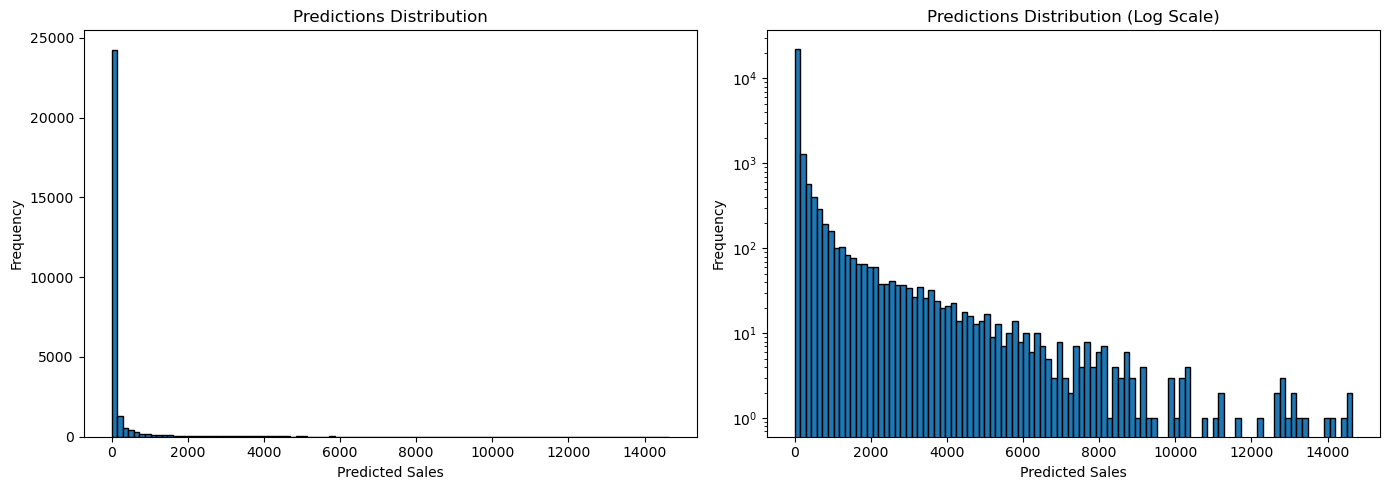


✓ All done! Good luck with your submission!


In [24]:
# ===== TAHAP 6: PREDICTION & SUBMISSION =====

print("="*50)
print("TAHAP 6: PREDICTION & SUBMISSION")
print("="*50)

# 1. PREDICT ON TEST DATA
print("\n1. Predicting on test data...")
print(f"Test data shape: {X_test.shape}")

# Make predictions (still in log scale)
predictions_log = model.predict(dtest)
print(f"✓ Predictions completed")
print(f"Predictions shape: {predictions_log.shape}")

# Show sample predictions (log scale)
print(f"\nSample predictions (log scale):")
print(predictions_log[:10])

# 2. INVERSE TRANSFORM - CRITICAL!
print("\n2. Inverse transform (log → original scale)...")
predictions = np.expm1(predictions_log)  # expm1 = exp(x) - 1, inverse of log1p
print(f"✓ Inverse transform completed")

# Show sample predictions (original scale)
print(f"\nSample predictions (original scale):")
print(predictions[:10])

# 3. CLIP NEGATIVE VALUES TO 0
print("\n3. Handling negative predictions...")
negative_count = (predictions < 0).sum()
print(f"Negative predictions: {negative_count}")

predictions = np.maximum(0, predictions)  # Clip to 0
print(f"✓ Negative values clipped to 0")

# 4. CREATE SUBMISSION DATAFRAME
print("\n4. Creating submission file...")
submission = pd.DataFrame({
    'id': test_id,
    'sales': predictions
})

print(f"Submission shape: {submission.shape}")
print(f"\nSubmission preview:")
print(submission.head(10))

# 5. VERIFY SUBMISSION
print("\n5. Verifying submission...")
print(f"✓ Shape matches sample_submission: {submission.shape == sample_submission.shape}")
print(f"✓ No missing values: {submission.isnull().sum().sum() == 0}")
print(f"✓ No negative values: {(submission['sales'] < 0).sum() == 0}")

# Statistics
print(f"\nPrediction Statistics:")
print(submission['sales'].describe())

# 7. COMPARISON WITH SAMPLE SUBMISSION
print("\n7. Comparison with sample submission:")
print(f"Sample submission shape: {sample_submission.shape}")
print(f"Our submission shape: {submission.shape}")
print(f"Columns match: {list(submission.columns) == list(sample_submission.columns)}")


# 8. OPTIONAL: Visualize predictions distribution
print("\n8. Prediction distribution:")
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(predictions, bins=100, edgecolor='black')
axes[0].set_title('Predictions Distribution')
axes[0].set_xlabel('Predicted Sales')
axes[0].set_ylabel('Frequency')

# Log scale histogram
axes[1].hist(predictions[predictions > 0], bins=100, edgecolor='black')
axes[1].set_title('Predictions Distribution (Log Scale)')
axes[1].set_xlabel('Predicted Sales')
axes[1].set_ylabel('Frequency')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

print("\n✓ All done! Good luck with your submission!")

In [25]:
# 4. PREDICT ON VALIDATION SET
print("\n4. Predicting on validation set...")

y_val_pred_log_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
y_val_pred_lgb = np.expm1(y_val_pred_log_lgb)
y_val_pred_lgb = np.maximum(0, y_val_pred_lgb)

print("✓ Predictions completed")


4. Predicting on validation set...
✓ Predictions completed


Evaluation Metrics

In [26]:
# ===== EVALUATION METRICS =====
from sklearn.metrics import mean_squared_error, mean_absolute_error

# NOTE: We can only evaluate on VALIDATION set, not test set
# because test set doesn't have actual sales values

print("\nEvaluating on VALIDATION SET...")
print("(Test set doesn't have actual sales, so we use validation for metrics)\n")

# 1. Get validation predictions (already calculated during training)
# Let's recalculate for clarity
y_val_pred_log = model.predict(dval)

# 2. Inverse transform both actual and predicted
y_val_actual = np.expm1(y_val)  # Actual sales (original scale)
y_val_pred = np.expm1(y_val_pred_log)  # Predicted sales (original scale)

# Clip negative predictions
y_val_pred = np.maximum(0, y_val_pred)

# 3. Calculate Metrics

# RMSLE - Root Mean Squared Logarithmic Error
rmsle = np.sqrt(mean_squared_error(np.log1p(y_val_actual), np.log1p(y_val_pred)))

# RMSE - Root Mean Squared Error (on original scale)
rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))

# MAE - Mean Absolute Error
mae = mean_absolute_error(y_val_actual, y_val_pred)

# MAPE - Mean Absolute Percentage Error
# Avoid division by zero: only calculate for non-zero actuals
non_zero_mask = y_val_actual > 0
if non_zero_mask.sum() > 0:
    mape = np.mean(np.abs((y_val_actual[non_zero_mask] - y_val_pred[non_zero_mask]) / y_val_actual[non_zero_mask])) * 100
else:
    mape = np.nan

# 4. Display Results
print("="*50)
print("XGBOOST VALIDATION SET METRICS:")
print("="*50)
print(f"RMSLE (Root Mean Squared Logarithmic Error): {rmsle:.6f}")
print(f"RMSE  (Root Mean Squared Error):             {rmse:.2f}")
print(f"MAE   (Mean Absolute Error):                 {mae:.2f}")
print(f"MAPE  (Mean Absolute Percentage Error):      {mape:.2f}%")
print("="*50)

# 5. Additional Info
print(f"\nValidation set size: {len(y_val_actual):,} samples")
print(f"Actual sales range: [{y_val_actual.min():.2f}, {y_val_actual.max():.2f}]")
print(f"Predicted sales range: [{y_val_pred.min():.2f}, {y_val_pred.max():.2f}]")

print("\nNote: RMSLE is the official Kaggle metric for this competition.")


Evaluating on VALIDATION SET...
(Test set doesn't have actual sales, so we use validation for metrics)

XGBOOST VALIDATION SET METRICS:
RMSLE (Root Mean Squared Logarithmic Error): 0.381558
RMSE  (Root Mean Squared Error):             257.30
MAE   (Mean Absolute Error):                 70.69
MAPE  (Mean Absolute Percentage Error):      33.09%

Validation set size: 26,730 samples
Actual sales range: [0.00, 15190.00]
Predicted sales range: [0.00, 15412.69]

Note: RMSLE is the official Kaggle metric for this competition.


In [27]:
# 5. CALCULATE METRICS

# Get actual values (already calculated before)
y_val_actual = np.expm1(y_val)

# RMSLE - Root Mean Squared Logarithmic Error
rmsle_lgb = np.sqrt(mean_squared_error(np.log1p(y_val_actual), np.log1p(y_val_pred_lgb)))

# RMSE - Root Mean Squared Error
rmse_lgb = np.sqrt(mean_squared_error(y_val_actual, y_val_pred_lgb))

# MAE - Mean Absolute Error
mae_lgb = mean_absolute_error(y_val_actual, y_val_pred_lgb)

# MAPE - Mean Absolute Percentage Error
non_zero_mask = y_val_actual > 0
mape_lgb = np.mean(np.abs((y_val_actual[non_zero_mask] - y_val_pred_lgb[non_zero_mask]) / y_val_actual[non_zero_mask])) * 100

# R² Score
from sklearn.metrics import r2_score
r2_lgb = r2_score(y_val_actual, y_val_pred_lgb)

# 6. DISPLAY METRICS
print("\n" + "="*50)
print("LIGHTGBM VALIDATION METRICS:")
print("="*50)
print(f"RMSLE (Root Mean Squared Logarithmic Error): {rmsle_lgb:.6f}")
print(f"RMSE  (Root Mean Squared Error):             {rmse_lgb:.2f}")
print(f"MAE   (Mean Absolute Error):                 {mae_lgb:.2f}")
print(f"MAPE  (Mean Absolute Percentage Error):      {mape_lgb:.2f}%")
print(f"R²    (R-squared Score):                     {r2_lgb:.6f}")
print("="*50)


LIGHTGBM VALIDATION METRICS:
RMSLE (Root Mean Squared Logarithmic Error): 0.377280
RMSE  (Root Mean Squared Error):             210.36
MAE   (Mean Absolute Error):                 61.43
MAPE  (Mean Absolute Percentage Error):      32.25%
R²    (R-squared Score):                     0.971417


Hyperparameter Tuning

In [28]:
# ===== MANUAL HYPERPARAMETER TUNING (FASTER) =====
print("="*50)
print("MANUAL HYPERPARAMETER TUNING - XGBOOST")
print("="*50)

import xgboost as xgb

# Stop the previous process if still running
print("Training with optimized parameters...")
print("This should take 5-10 minutes...\n")

# OPTIMIZED PARAMETERS (based on best practices for retail forecasting)
params_tuned = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,                    # Lower learning rate for better accuracy
    'max_depth': 10,                # Deeper trees
    'min_child_weight': 1,          # Less restrictive
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,                   # Small regularization
    'reg_alpha': 0.01,              # L1 regularization
    'reg_lambda': 2,                # L2 regularization
    'seed': 42,
    'tree_method': 'hist',
    'verbosity': 1
}

print("Optimized Parameters:")
for key, value in params_tuned.items():
    print(f"  {key}: {value}")

# Prepare data
dtrain_tuned = xgb.DMatrix(X_tr, label=y_tr)
dval_tuned = xgb.DMatrix(X_val, label=y_val)

# Train model
num_rounds = 1000
early_stopping_rounds = 100

print(f"\nTraining with {num_rounds} rounds and early stopping...")

evals = [(dtrain_tuned, 'train'), (dval_tuned, 'val')]

tuned_model = xgb.train(
    params=params_tuned,
    dtrain=dtrain_tuned,
    num_boost_round=num_rounds,
    evals=evals,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=100
)

print(f"\n✓ Training completed!")
print(f"Best iteration: {tuned_model.best_iteration}")
print(f"Best score: {tuned_model.best_score:.6f}")

# Evaluate
print("\nEvaluating tuned model on validation set...")
y_val_pred_log_tuned = tuned_model.predict(dval_tuned)
y_val_pred_tuned = np.expm1(y_val_pred_log_tuned)
y_val_pred_tuned = np.maximum(0, y_val_pred_tuned)

# Calculate metrics
rmsle_tuned = np.sqrt(mean_squared_error(np.log1p(y_val_actual), np.log1p(y_val_pred_tuned)))
rmse_tuned = np.sqrt(mean_squared_error(y_val_actual, y_val_pred_tuned))
mae_tuned = mean_absolute_error(y_val_actual, y_val_pred_tuned)

non_zero_mask = y_val_actual > 0
mape_tuned = np.mean(np.abs((y_val_actual[non_zero_mask] - y_val_pred_tuned[non_zero_mask]) / y_val_actual[non_zero_mask])) * 100

# COMPARISON
print("\n" + "="*50)
print("BEFORE vs AFTER TUNING:")
print("="*50)
print(f"{'Metric':<10} {'Before':<15} {'After':<15} {'Improvement':<15}")
print("-" * 55)
print(f"{'RMSLE':<10} {rmsle:.6f}{'':<8} {rmsle_tuned:.6f}{'':<8} {rmsle - rmsle_tuned:+.6f}")
print(f"{'RMSE':<10} {rmse:.2f}{'':<10} {rmse_tuned:.2f}{'':<10} {rmse - rmse_tuned:+.2f}")
print(f"{'MAE':<10} {mae:.2f}{'':<10} {mae_tuned:.2f}{'':<10} {mae - mae_tuned:+.2f}")
print(f"{'MAPE':<10} {mape:.2f}%{'':<9} {mape_tuned:.2f}%{'':<9} {mape - mape_tuned:+.2f}%")
print("="*50)

# Feature Importance
print("\nTop 20 Feature Importance (Tuned Model):")
importance_dict = tuned_model.get_score(importance_type='gain')
importance_sorted = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]

for i, (feature, score) in enumerate(importance_sorted, 1):
    print(f"{i:2d}. {feature:30s}: {score:.2f}")

print("\n✓ Manual hyperparameter tuning completed!")

MANUAL HYPERPARAMETER TUNING - XGBOOST
Training with optimized parameters...
This should take 5-10 minutes...

Optimized Parameters:
  objective: reg:squarederror
  eval_metric: rmse
  eta: 0.05
  max_depth: 10
  min_child_weight: 1
  subsample: 0.8
  colsample_bytree: 0.8
  gamma: 0.1
  reg_alpha: 0.01
  reg_lambda: 2
  seed: 42
  tree_method: hist
  verbosity: 1

Training with 1000 rounds and early stopping...
[0]	train-rmse:2.56474	val-rmse:2.49105
[100]	train-rmse:0.38195	val-rmse:0.38618
[200]	train-rmse:0.35985	val-rmse:0.38059
[300]	train-rmse:0.34935	val-rmse:0.37737
[400]	train-rmse:0.34220	val-rmse:0.37584
[500]	train-rmse:0.33613	val-rmse:0.37500
[600]	train-rmse:0.33105	val-rmse:0.37479
[700]	train-rmse:0.32601	val-rmse:0.37447
[794]	train-rmse:0.32188	val-rmse:0.37432

✓ Training completed!
Best iteration: 694
Best score: 0.374263

Evaluating tuned model on validation set...

BEFORE vs AFTER TUNING:
Metric     Before          After           Improvement    
---------------


LIGHTGBM VALIDATION METRICS:
RMSLE (Root Mean Squared Logarithmic Error): 0.377280
RMSE  (Root Mean Squared Error):             210.36
MAE   (Mean Absolute Error):                 61.43
MAPE  (Mean Absolute Percentage Error):      32.25%
R²    (R-squared Score):                     0.971417

8. Top 20 Feature Importance (LightGBM):
sales_rolling_mean_7          : 140616203
sales_rolling_mean_14         : 23638619
sales_lag_7                   : 4471742
sales_lag_14                  : 1188033
is_year_start                 : 856955
sales_rolling_std_7           : 840541
day_of_week                   : 547186
sales_lag_28                  : 409730
family_encoded                : 343207
day_of_year                   : 311939
sales_rolling_mean_28         : 240238
day                           : 228307
dcoilwtico                    : 220385
onpromotion                   : 127967
store_nbr                     : 65060
year                          : 53828
week_of_year                  : 4457

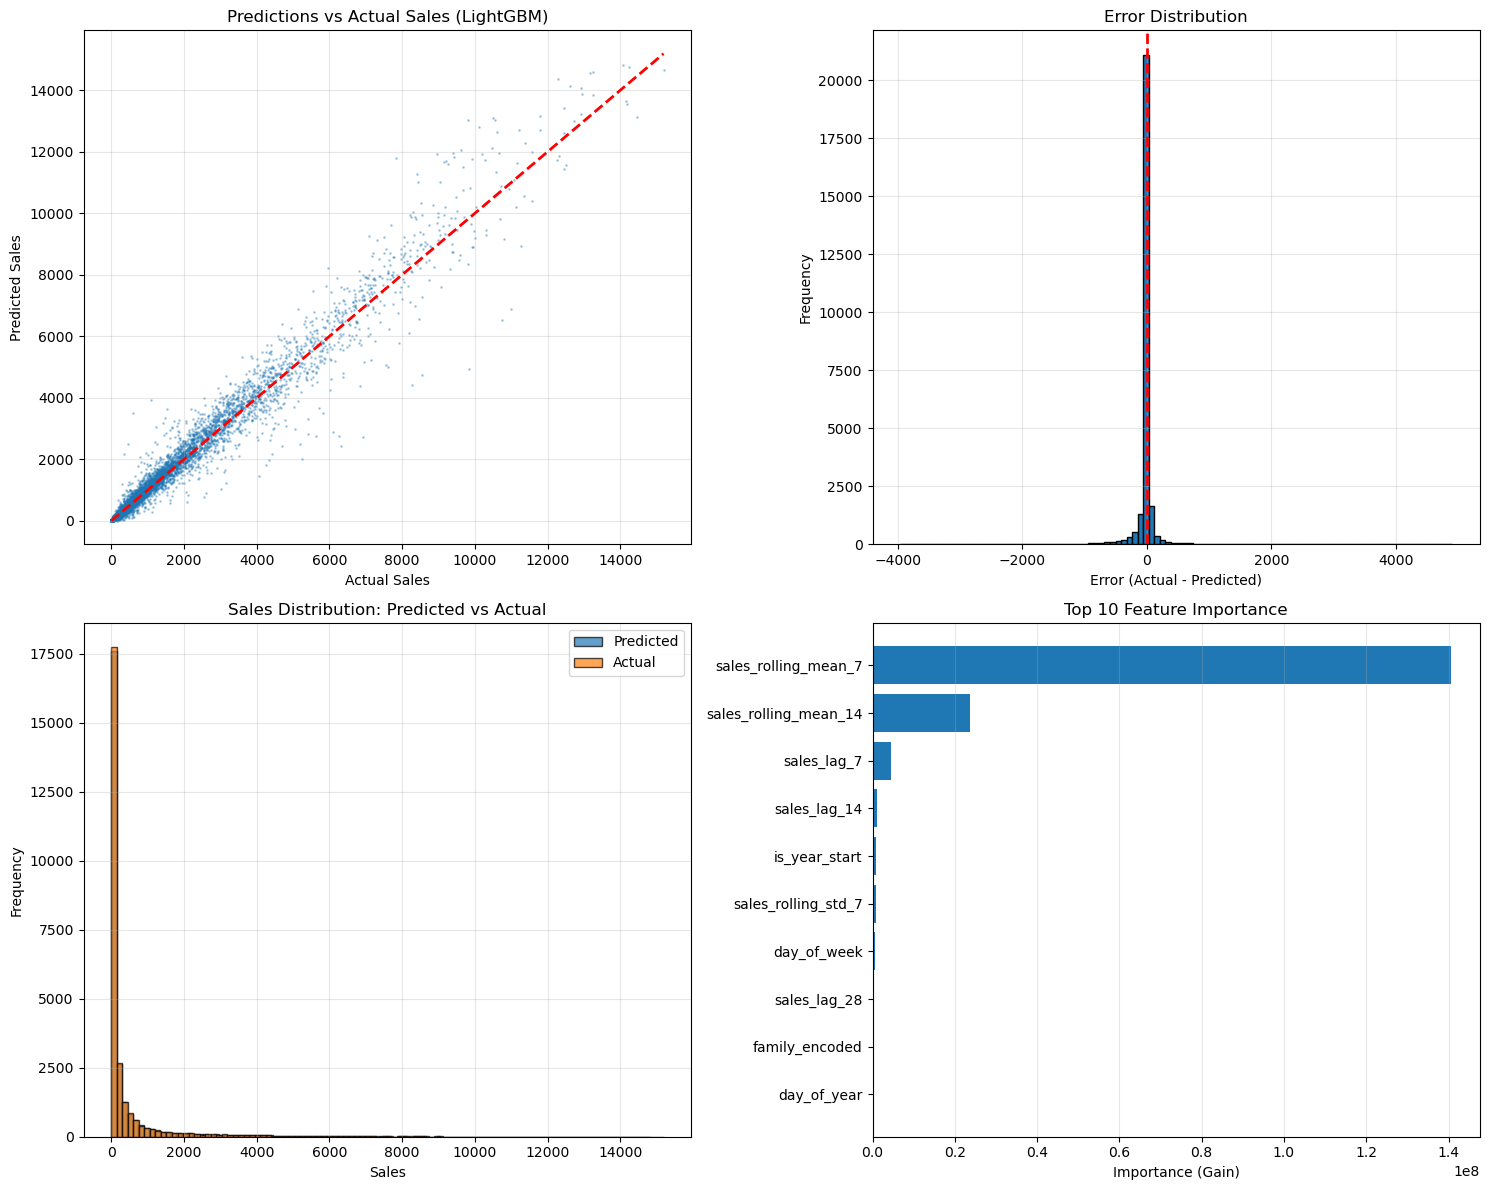

In [29]:
# 6. DISPLAY METRICS
print("\n" + "="*50)
print("LIGHTGBM VALIDATION METRICS:")
print("="*50)
print(f"RMSLE (Root Mean Squared Logarithmic Error): {rmsle_lgb:.6f}")
print(f"RMSE  (Root Mean Squared Error):             {rmse_lgb:.2f}")
print(f"MAE   (Mean Absolute Error):                 {mae_lgb:.2f}")
print(f"MAPE  (Mean Absolute Percentage Error):      {mape_lgb:.2f}%")
print(f"R²    (R-squared Score):                     {r2_lgb:.6f}")
print("="*50)

# 8. FEATURE IMPORTANCE
print("\n8. Top 20 Feature Importance (LightGBM):")
feature_importance_lgb = lgb_model.feature_importance(importance_type='gain')
importance_df_lgb = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance_lgb
}).sort_values('importance', ascending=False).head(20)

for i, row in importance_df_lgb.iterrows():
    print(f"{row['feature']:30s}: {row['importance']:.0f}")

# 9. PREDICTION ANALYSIS
print("\n9. Prediction Analysis:")
print(f"Actual sales range:    [{y_val_actual.min():.2f}, {y_val_actual.max():.2f}]")
print(f"Predicted sales range: [{y_val_pred_lgb.min():.2f}, {y_val_pred_lgb.max():.2f}]")
print(f"\nActual sales statistics:")
print(f"  Mean:   {y_val_actual.mean():.2f}")
print(f"  Median: {np.median(y_val_actual):.2f}")
print(f"  Std:    {y_val_actual.std():.2f}")
print(f"\nPredicted sales statistics:")
print(f"  Mean:   {y_val_pred_lgb.mean():.2f}")
print(f"  Median: {np.median(y_val_pred_lgb):.2f}")
print(f"  Std:    {y_val_pred_lgb.std():.2f}")

# 10. ERROR DISTRIBUTION
print("\n10. Error Distribution:")
errors = y_val_actual - y_val_pred_lgb
print(f"Mean Error:     {errors.mean():.2f}")
print(f"Median Error:   {np.median(errors):.2f}")
print(f"Std Error:      {errors.std():.2f}")
print(f"Min Error:      {errors.min():.2f}")
print(f"Max Error:      {errors.max():.2f}")

# Percentage of predictions within certain error ranges
within_10 = (np.abs(errors) <= 10).sum() / len(errors) * 100
within_50 = (np.abs(errors) <= 50).sum() / len(errors) * 100
within_100 = (np.abs(errors) <= 100).sum() / len(errors) * 100

print(f"\nPredictions within error range:")
print(f"  ±10 units:  {within_10:.2f}%")
print(f"  ±50 units:  {within_50:.2f}%")
print(f"  ±100 units: {within_100:.2f}%")

print("\n✓ LightGBM training and evaluation completed!")

# Visualize predictions vs actual
print("\n11. Visualization...")
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Predictions vs Actual (scatter plot)
axes[0, 0].scatter(y_val_actual, y_val_pred_lgb, alpha=0.3, s=1)
axes[0, 0].plot([0, y_val_actual.max()], [0, y_val_actual.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Sales')
axes[0, 0].set_ylabel('Predicted Sales')
axes[0, 0].set_title('Predictions vs Actual Sales (LightGBM)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Error distribution
axes[0, 1].hist(errors, bins=100, edgecolor='black')
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Error (Actual - Predicted)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Error Distribution')
axes[0, 1].grid(True, alpha=0.3)

# 3. Predictions distribution
axes[1, 0].hist(y_val_pred_lgb, bins=100, alpha=0.7, label='Predicted', edgecolor='black')
axes[1, 0].hist(y_val_actual, bins=100, alpha=0.7, label='Actual', edgecolor='black')
axes[1, 0].set_xlabel('Sales')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Sales Distribution: Predicted vs Actual')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Feature importance (top 10)
top_features = importance_df_lgb.head(10)
axes[1, 1].barh(range(len(top_features)), top_features['importance'])
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['feature'])
axes[1, 1].set_xlabel('Importance (Gain)')
axes[1, 1].set_title('Top 10 Feature Importance')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

Conclusion

In [30]:
# 7. COMPARISON: XGBOOST vs LIGHTGBM
print("\n" + "="*50)
print("XGBOOST vs LIGHTGBM COMPARISON:")
print("="*50)
print(f"{'Metric':<10} {'XGBoost (Tuned)':<20} {'LightGBM':<20} {'Improvement':<15}")
print("-" * 65)
print(f"{'RMSLE':<10} {rmsle_tuned:.6f}{'':<13} {rmsle_lgb:.6f}{'':<13} {rmsle_tuned - rmsle_lgb:+.6f}")
print(f"{'RMSE':<10} {rmse_tuned:.2f}{'':<15} {rmse_lgb:.2f}{'':<15} {rmse_tuned - rmse_lgb:+.2f}")
print(f"{'MAE':<10} {mae_tuned:.2f}{'':<15} {mae_lgb:.2f}{'':<15} {mae_tuned - mae_lgb:+.2f}")
print(f"{'MAPE':<10} {mape_tuned:.2f}%{'':<14} {mape_lgb:.2f}%{'':<14} {mape_tuned - mape_lgb:+.2f}%")
print("="*65)

print("\n" + "="*50)
print("SUMMARY:")
print("="*50)
print(f"LightGBM achieved RMSLE: {rmsle_lgb:.6f}")
if rmsle_lgb < rmsle_tuned:
    print(f"✓ LightGBM is BETTER than XGBoost by {rmsle_tuned - rmsle_lgb:.6f}")
else:
    print(f"✗ XGBoost is still better by {rmsle_lgb - rmsle_tuned:.6f}")
print("="*50)


XGBOOST vs LIGHTGBM COMPARISON:
Metric     XGBoost (Tuned)      LightGBM             Improvement    
-----------------------------------------------------------------
RMSLE      0.374272              0.377280              -0.003008
RMSE       202.69                210.36                -7.67
MAE        58.39                61.43                -3.04
MAPE       32.06%               32.25%               -0.19%

SUMMARY:
LightGBM achieved RMSLE: 0.377280
✗ XGBoost is still better by 0.003008
